In [12]:
import os

# Get the current working directory
cwd = os.getcwd()

# Construct the file path
print(file_path)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/surfhound-compute/code/Users/Owen.Rotich/Users/Owen.Rotich/


In [13]:
import sys

# Add the directory containing utils.py to the Python path
sys.path.append(os.path.dirname(file_path))

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import pickle
from utils import Preprocessor
import numpy as np

In [18]:
# Load dataset
df = pd.read_csv('phishing_site_urls.csv')

EXPLORATORY DATASET ANALYSIS

In [19]:
# basic info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     549346 non-null  object
 1   label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


,url,label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.onion.to/,good
freq,52,392924


In [20]:
# find duplicates
df.duplicated().sum()

42150

In [21]:
# check the data types
df.dtypes

url      object
label    object
dtype: object

In [22]:
# print the number of bad vs good URLs
label_counts = df['label'].value_counts()
print(f'Number of bad URLs: {label_counts["bad"]}')
print(f'Number of good URLs: {label_counts["good"]}')

Number of bad URLs: 156422
Number of good URLs: 392924


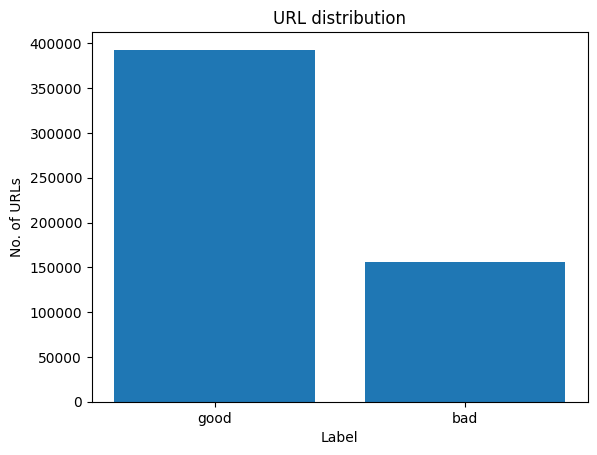

In [23]:
# plot number of URLs in each label
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('No. of URLs')
plt.title('URL distribution')
plt.show()

In [24]:
# Data Cleaning
df = df.dropna()  # remove missing values
df = df.drop_duplicates()  # remove duplicates
df['url'] = df['url'].str.lower()  # convert to lowercase

In [25]:
# Convert labels to binary format ('good' -> 1, 'bad' -> 0)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [26]:
# Initialize the preprocessor and transform the data
preprocessor = Preprocessor()
X = preprocessor.fit_transform(df)
y = df['label']

length of sequences: 177


In [27]:
# Split the data into training and test sets
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [28]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_tr.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

2023-11-15 15:20:14.893766: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-15 15:20:14.894290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (surfhound-compute): /proc/driver/nvidia/version does not exist
2023-11-15 15:20:14.901018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_tr, y_tr, epochs=50, batch_size=32, validation_data=(X_ts, y_ts), class_weight=dict(enumerate(class_weights)), callbacks=[early_stopping])


2023-11-15 15:20:16.163412: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1624647024 exceeds 10% of free system memory.
2023-11-15 15:20:52.091421: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 406165760 exceeds 10% of free system memory.


Epoch 1/50
12680/12680 [==============================] - 38s 3ms/step - loss: 0.4072 - accuracy: 0.8394 - val_loss: 0.2865 - val_accuracy: 0.8717
Epoch 2/50
12680/12680 [==============================] - 36s 3ms/step - loss: 0.3436 - accuracy: 0.8542 - val_loss: 0.2866 - val_accuracy: 0.8708
Epoch 3/50
12680/12680 [==============================] - 38s 3ms/step - loss: 0.3272 - accuracy: 0.8595 - val_loss: 0.2712 - val_accuracy: 0.8776
Epoch 4/50
12680/12680 [==============================] - 38s 3ms/step - loss: 0.3191 - accuracy: 0.8646 - val_loss: 0.2540 - val_accuracy: 0.8877
Epoch 5/50
12680/12680 [==============================] - 36s 3ms/step - loss: 0.3112 - accuracy: 0.8661 - val_loss: 0.2365 - val_accuracy: 0.8978
Epoch 6/50
12680/12680 [==================

In [31]:
# Evaluate the model
y_pred = model.predict(X_ts)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_ts, y_pred))
print(confusion_matrix(y_ts, y_pred))

2023-11-15 15:25:15.094728: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 406165760 exceeds 10% of free system memory.


3170/3170 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.72      0.88      0.79     22704
           1       0.96      0.90      0.93     78736

    accuracy                           0.90    101440
   macro avg       0.84      0.89      0.86    101440
weighted avg       0.91      0.90      0.90    101440

[[19940  2764]
 [ 7600 71136]]


In [35]:
# Save the model and preprocessor
model.save(f'surfhound.h5')
with open(f'preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [36]:
def is_phishing_url(url):
    # Load the preprocessor and the model
    with open('preprocessor.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    model = load_model('surfhound.h5')

    # Preprocess the URL
    df = pd.DataFrame([[url, None ]], columns=['url','label'])
    X = preprocessor.transform(df)
    print(df)

    # Make a prediction
    prediction = model.predict(X)

    # Return True if the URL is predicted to be phishing, False otherwise
    if prediction[0][0] < 0.5:
      return True
    else:
      return False

In [37]:
while(True):
    bad_url = input("Enter a url: ")
    print(is_phishing_url(bad_url))

          url label  url_length  num_digits  num_letters  num_special_chars  \
0  google.com  None          10           0            9                  1   

   num_dots  num_slashes  num_hyphens  num_subdomains  has_https  tld_length  \
0         1            0            0               1          0           3   

   has_ip  has_redirects  
0       0              0  
1/1 [==============================] - 0s 67ms/step
False
                url label  url_length  num_digits  num_letters  \
0  123phishingisurl  None          16           3           13   

   num_special_chars  num_dots  num_slashes  num_hyphens  num_subdomains  \
0                  0         0            0            0               0   

   has_https  tld_length  has_ip  has_redirects  
0          0           0       0              0  
1/1 [==============================] - 0s 107ms/step
True
                  url label  url_length  nu